### Imports

In [546]:
import numpy as np
import pandas as pd
import ace_tools_open as tools
from case_studies import *
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [547]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f3, f4, f5]
dfs = [df1, df3, df4, df5]
Hfs = [Hf1, Hf3, Hf4, Hf5]
fnames = ["f1", "f3", "f4", "f5"]

fsAN = [f1, f4]
dfsAN = [df1, df4]
HfsAN = [Hf1, Hf4]
fnamesAN = ["f1", "f4"]

In [548]:
def backtracking_line_search(f, df, x, pk, alpha_init, c1, rho):
    
    alpha = alpha_init
    while f(x + alpha * pk) > f(x) + c1 * alpha * np.dot(df(x), pk):
        alpha *= rho
    return alpha

In [549]:
#Max iter afhænger nok af newton som kalder CG, måske skal det hedde noget andet
def conjugate_gradients(Q, g, eps, max_iter=1000):
    x = 0
    grad = g
    p = -grad
    for _ in range(max_iter):
        Qp = np.dot(Q, p)
        alpha_k = -(np.dot(p, grad) / np.dot(p, Qp))

        x = x + alpha_k * p
        
        grad = np.dot(Q, x) + g
        
        if np.linalg.norm(grad) < eps:
            break

        p = -grad + (np.dot(grad, Qp) / np.dot(p, Qp)) * p
        grad = grad
    return x

In [550]:
def approximate_newton(x, f, df, hf, c1=1e-4, rho=0.9, max_iter=1000, tol=1e-9):
    xs = [x]
    for _ in range(max_iter):

        if np.linalg.norm(df(x)) < tol:
            break 
        
        n_k = min(0.5, np.linalg.norm(df(x)))
        #n_k = 0.5 * min(0.5, np.sqrt(np.linalg.norm(df(x))))
        eps = n_k * np.linalg.norm(df(x))
        p = conjugate_gradients(hf(x), df(x), eps)
        alpha = backtracking_line_search(f, df, x, p, 1.0, c1, rho)
        x = x + alpha * p
        xs.append(x)
    return x, xs, 

In [551]:
def newtons_method(x0, f, grad_f, hessian_f, c1=1e-4, rho=0.9, tol=1e-9, max_iters=1000):
    x = x0
    xs = [x0]
    
    for _ in range(max_iters):
        grad = grad_f(x)
        hessian = hessian_f(x)
        
        if np.linalg.norm(grad) < tol:
            break 
        
        if np.all(np.linalg.eigvals(hessian) > 0):
            p = -np.linalg.solve(hessian, grad)
        else:
            eigvals, eigvecs = np.linalg.eigh(hessian)
            H = sum((1 / abs(eigval)) * np.outer(eigvec, eigvec) for eigval, eigvec in zip(eigvals, eigvecs))
            p = -H @ grad
        
        alpha = backtracking_line_search(f, grad_f, x, p, 1.0, c1, rho)
        x = x + alpha * p
        xs.append(x)
    
    return x, xs

### scipy BFGS

In [552]:
def scipy_bfgs(f,df,x0,max_iterations=1000,epsilon=1e-9):
    xs=[]
    grad_norms=[]
    def logging_f(x):
        xs.append(x)
        grad_norms.append(np.maximum(np.linalg.norm(df(x)),10**(-5)*epsilon))
        return f(x)
    minimize(logging_f, x0, method="BFGS", jac=df, tol=epsilon,options={'maxiter':max_iterations, 'gtol':epsilon})
    return np.array(xs), np.array(grad_norms)

### Strict Wolfe condition Linesearch

In [553]:
def wolfe_search(f, df, x, p, c1, c2, alpha_init):
    branch1 = 0
    branch2 = 0
    branch3 = 0
    branch4 = 0
    branch5 = 0
    branch6 = 0
    branch7 = 0
    branch8 = 0
    def gf(alpha):
        return f(x + np.dot(alpha, p))
    def g_prime(alpha):
        return np.dot(df(x + np.dot(alpha, p)), p)
    l = 0
    u = alpha_init
    while True:
        if gf(u) > (gf(0) + c1 * u * g_prime(0)) or gf(u) > gf(l):
            branch1 = 1
            break
        if abs(g_prime(u)) < c2 * abs(g_prime(0)):
            branch2 = 2
            alpha_star = u
            return alpha_star, (branch1, branch2, branch3, branch4, branch5, branch6, branch7, branch8)
        if g_prime(u) > 0:
            branch3 = 3
            break
        else:
            u = u * 2
            branch4 = 4
    while True:
        a = (l + u) / 2
        if gf(a) > (gf(0) + c1 * a * g_prime(0)) or gf(a) > gf(l):
            branch5 = 5
            u = a
        else:
            if abs(g_prime(a)) < c2 * abs(g_prime(0)):
                branch6 = 6
                alpha_star = a
                return alpha_star, (branch1, branch2, branch3, branch4, branch5, branch6, branch7, branch8)
            if g_prime(a) < 0:
                branch7 = 7
                l = a
            else:
                branch8 = 8
                u = a

### BFGS

In [554]:
def bfgs(x, f, df, c1=1e-4, c2=0.9, max_iter=1000, tol=1e-9):
    # eye tager dimension
    H = np.eye(20)
    xs = []
    wolfe_results = []
    for _ in range(max_iter):
        p = -np.dot(H, df(x))
        alpha, branches = wolfe_search(f, df, x, p, c1, c2, 1.0)
        wolfe_results.append(branches)
        avg_wolfe_results = np.mean(wolfe_results, axis=0)
        ap = np.dot(alpha, p)
        x_new = x + ap
        y = df(x_new) - df(x)
        s = ap
        first_term = (np.dot(s.T, y) + np.dot(y.T, np.dot(H, y)))/ ((np.dot(s.T, y))**2)
        second_term = (np.dot(H, np.outer(y,s.T))+ np.dot(np.outer(s,y.T), H))/(np.dot(s.T, y))
        H = H + first_term * np.outer(s, s) - second_term
        x = x_new
        xs.append(x)
        if np.linalg.norm(df(x)) < tol:
            break
    return x, xs, avg_wolfe_results

In [555]:
d = 20
x0 = np.random.randn(d)  
x, xs, avg_wolfe_results = bfgs(x0, f3, df3)
print(avg_wolfe_results)

[0.81981982 0.34234234 0.02702703 0.10810811 3.69369369 4.97297297
 0.         0.57657658]


In [556]:
def benchmark(f, df, optimizer, x0, x_opt, Hf=None):
    start_time = time.time()
    if optimizer == bfgs:
        x_final, xs, _ = optimizer(x0, f, df)
    if optimizer == scipy_bfgs:
        xs, _ = optimizer(f, df, x0)
        x_final = xs[-1]
    if optimizer == newtons_method:
        x_final, xs = optimizer(x0, f, df, Hf)
    if optimizer == approximate_newton:
        x_final, xs = optimizer(x0, f, df, Hf)
    end_time = time.time()

    num_iterations = len(xs)
    final_solution_point = x_final
    dist_to_optimum = np.linalg.norm(x_final-x_opt)
    final_fun_value = f(xs[-1])
    duration = end_time-start_time
    
    grad_norms = [np.linalg.norm(df(x)) for x in xs]
    if optimizer == approximate_newton:
        return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms, grad_norms[-1])

    return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms, grad_norms[-1])


In [557]:
SEED = 10
np.random.seed(SEED)

d = 20
num_runs = 500

benchmark_results = []


for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(f, d)

    #Original Newtons Method
    for _ in range(num_runs):
        x0 = np.random.randn(d)  
        sd_result = benchmark(f, df, newtons_method, x0, x_optimal, Hf)
        benchmark_results.append((fname, "Newtons Method") + sd_result)

        # scipy_bfgs
        sd_result = benchmark(f, df, scipy_bfgs, x0, x_optimal)
        benchmark_results.append((fname, "scipy BFGS") + sd_result)
        
        #BFGS
        sd_result = benchmark(f, df, bfgs, x0, x_optimal)
        benchmark_results.append((fname, "BFGS") + sd_result)

        if f == f1 or f == f4:
            sd_result = benchmark(f, df, approximate_newton, x0, x_optimal, Hf)
            benchmark_results.append((fname, "Approximate Newton") + sd_result)

# Convert to DataFrame
columns = ["Function", "Optimizer", "Iterations", "Time", "Final Function Value", "Final Solution Point", "Distance to Optimum", "Gradient Norms", "Final Gradient Norm"]
df_results = pd.DataFrame(benchmark_results, columns=columns)

df_display = df_results.drop(columns=["Final Solution Point", "Gradient Norms"])
tools.display_dataframe_to_user(name="Benchmark Results", dataframe=df_display)

KeyboardInterrupt: 

In [ ]:
df_avg_results = df_results.groupby(["Function", "Optimizer"]).agg({
    "Iterations": "mean",
    "Time": "mean",
    "Final Function Value": "mean",
    "Distance to Optimum": "mean",
    "Final Gradient Norm": "mean"
}).reset_index()

# Display the final averaged results
tools.display_dataframe_to_user(name="Averaged Optimization Results", dataframe=df_avg_results)

Averaged Optimization Results


In [ ]:
df_avg_results_no_scipy = df_avg_results[df_avg_results["Optimizer"] != "scipy BFGS"]
tools.display_dataframe_to_user(name="Averaged Optimization Results", dataframe=df_avg_results)

In [ ]:
def extract_grad_norms(df, function_name, optimizer_name):
    return df[(df["Function"] == function_name) &  (df["Optimizer"] == optimizer_name)]["Gradient Norms"].tolist()


def pad_grad_norms(grad_norms_list):
    max_length_run = max(len(run) for run in grad_norms_list)
    #print(max_length_run)
    padded_runs = []

    for run in grad_norms_list:
        padded_run = np.pad(run, (0, max_length_run - len(run)), mode="constant", constant_values=0)
        padded_runs.append(padded_run)
    
    return padded_runs

def get_avg_grad_norms(df, function_name, optimizer_name):

    grad_norms = extract_grad_norms(df, function_name, optimizer_name)
    padded_grad_norms = pad_grad_norms(grad_norms)
    mean_grad_norms = np.mean(padded_grad_norms, axis=0)

    return mean_grad_norms

In [ ]:
f1_newton_avg = get_avg_grad_norms(df_results, "f1", "Newtons Method")
f3_newton_avg = get_avg_grad_norms(df_results, "f4", "Newtons Method")
f4_newton_avg = get_avg_grad_norms(df_results, "f4", "Newtons Method")
f5_newton_avg = get_avg_grad_norms(df_results, "f4", "Newtons Method")

f1_bfgs_avg = get_avg_grad_norms(df_results, "f1", "BFGS")
f3_bfgs_avg = get_avg_grad_norms(df_results, "f3", "BFGS")
f4_bfgs_avg = get_avg_grad_norms(df_results, "f4", "BFGS")
f5_bfgs_avg = get_avg_grad_norms(df_results, "f5", "BFGS")

f1_scipy_bfgs_avg = get_avg_grad_norms(df_results, "f1", "scipy BFGS")
f3_scipy_bfgs_avg = get_avg_grad_norms(df_results, "f3", "scipy BFGS")
f4_scipy_bfgs_avg = get_avg_grad_norms(df_results, "f4", "scipy BFGS")
f5_scipy_bfgs_avg = get_avg_grad_norms(df_results, "f5", "scipy BFGS")

f1_appnewton_avg = get_avg_grad_norms(df_results, "f1", "Approximate Newton")
f4_appnewton_avg = get_avg_grad_norms(df_results, "f4", "Approximate Newton")

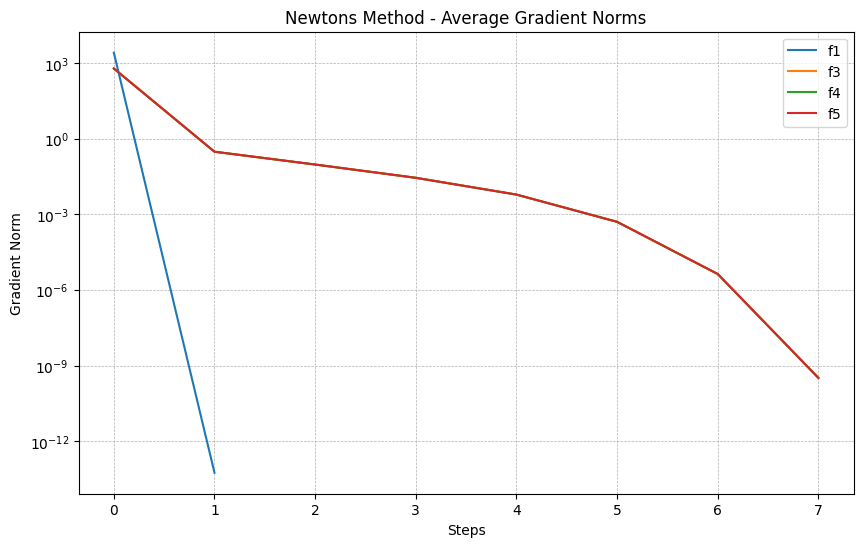

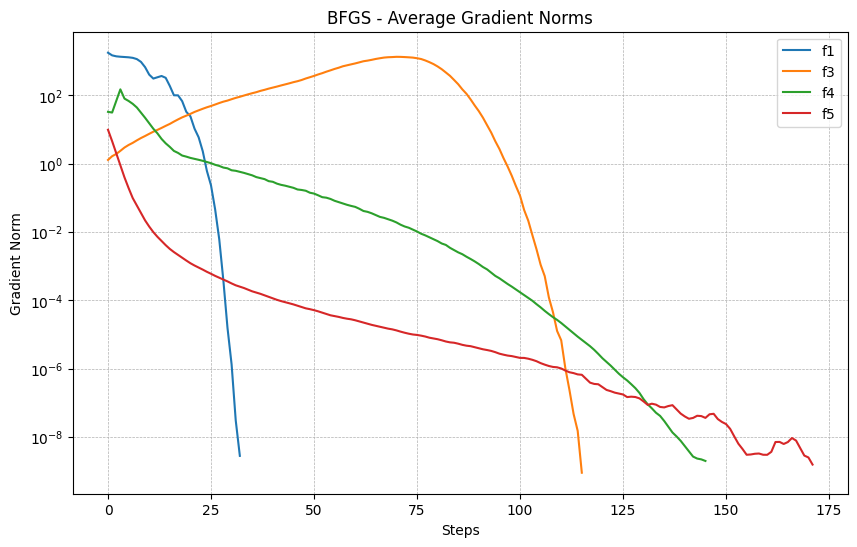

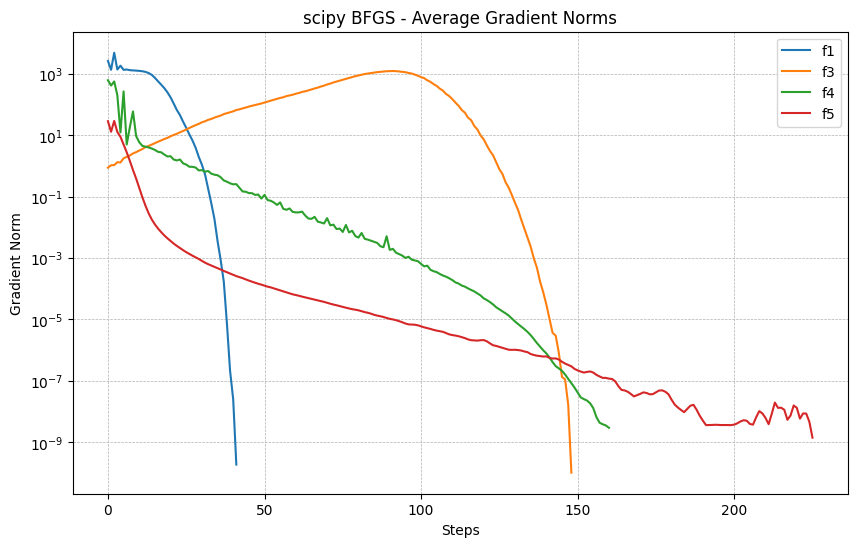

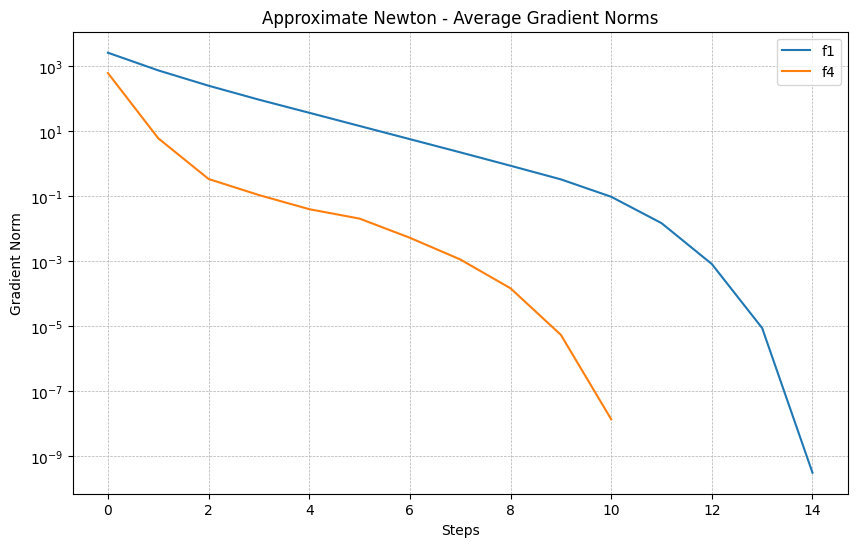

In [ ]:
def plot_convergence(title, f1_avg, f3_avg, f4_avg, f5_avg):
    plt.figure(figsize=(10, 6))

    plt.plot(range(len(f1_avg)), f1_avg, label="f1")
    plt.plot(range(len(f3_avg)), f3_avg, label="f3")
    plt.plot(range(len(f4_avg)), f4_avg, label="f4")
    plt.plot(range(len(f5_avg)), f5_avg, label="f5")

    plt.xlabel("Steps")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

def plot_convergence_AN(title, f1_avg, f4_avg):
    plt.figure(figsize=(10, 6))

    plt.plot(range(len(f1_avg)), f1_avg, label="f1")
    plt.plot(range(len(f4_avg)), f4_avg, label="f4")

    plt.xlabel("Steps")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

plot_convergence("Newtons Method - Average Gradient Norms", f1_newton_avg, f3_newton_avg, f4_newton_avg, f5_newton_avg)
plot_convergence("BFGS - Average Gradient Norms", f1_bfgs_avg, f3_bfgs_avg, f4_bfgs_avg, f5_bfgs_avg)
plot_convergence("scipy BFGS - Average Gradient Norms", f1_scipy_bfgs_avg, f3_scipy_bfgs_avg, f4_scipy_bfgs_avg, f5_scipy_bfgs_avg)
plot_convergence_AN("Approximate Newton - Average Gradient Norms", f1_appnewton_avg, f4_appnewton_avg)
